# Optimizing German traffic signs classification


The training images are divided into different folders which each folder named with a namber which correspond to class of the images. So we should first read images from disk and save them into the memory. Also the labels of test set saved in a CSV file and all images of different class saved in one folder. The images have different sizes, so before feeding into the model we should resize all of them into same dimension (here 32x32 pixel).

I divided this notebook into 3 parts, first part is loading and converting them into same size, second part is defining a CNN model and optimize it. Finally check model with test set and show which signs are misclassified.

In [1]:
# import libraries
import numpy as np
import tensorflow as tf
import os
import time
from datetime import timedelta
from matplotlib import pyplot as plt
from skimage import data
from skimage import transform
from pandas import read_csv

In [2]:
### Read data from file
# set data path
train_path = "data/Trainset/"
test_path = "data/Testset/Online-Test/Images"
test_csv_path = "data/Testset/Online-Test/GT-online_test.csv"

## first read training data
# list all sub folders
directories = [d for d in os.listdir(train_path)
              if os.path.isdir(os.path.join(train_path, d))]

train_images = []
labels_tr = []

# loop over all sub folders 
for d in directories:
    # Get the list of all images in this subfolder if the file end with .ppm
    current_dir = os.path.join(train_path, d)
    file_names = [os.path.join(current_dir, f)
                   for f in os.listdir(current_dir)
                   if f.endswith(".ppm")]
    
    # now loop over all listed image names
    for f in file_names:
        # Load them into the momory
        train_images.append(data.imread(f))
        
        # add the corresponding class of image to labels list
        labels_tr.append(int(d))

Let see what is the size of training set and show an example of its sign.

size of train-set:26640


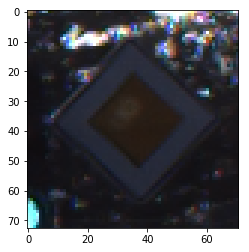

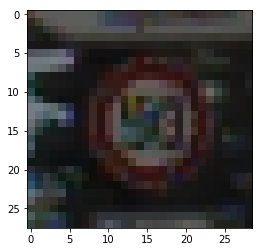

In [3]:
# let see what is a sign?!
print("size of train-set:{}".format(len(train_images)))
plt.imshow(train_images[999])
plt.show()
plt.imshow(train_images[2000])
plt.show()

As we can see, the size of images are different!

Now, we load the test set.

In [4]:
# Get the list of imagenames if it ends with ppm
file_names = [os.path.join(test_path, f)
            for f in os.listdir(test_path)
            if f.endswith(".ppm")]

# sort file names to be equal of labels in CSV files
file_names.sort()

test_images = []
# load images into the memory
for f in file_names:
    test_images.append(data.imread(f))


size of test set: 12569


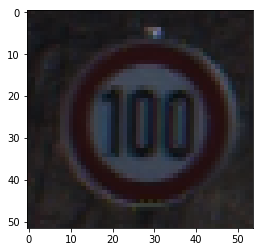

In [5]:
# show how many images we have in the test set
print("size of test set: {}".format(len(test_images)))
plt.imshow(test_images[0])
plt.show()

In [6]:
# Load test set labels from csv file
test_labels_csv = read_csv(test_csv_path,sep=';')
# Convert panda object to a list
test_labels = test_labels_csv.ClassId[:].values

Show the histogram of width and height of images.

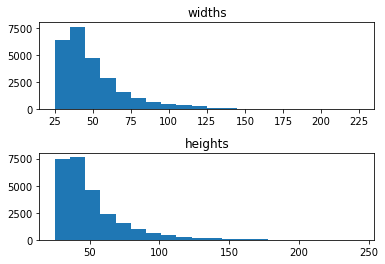

In [7]:
# check the size of images
widths = [i.shape[0] for i in train_images]
heights = [i.shape[1] for i in train_images]
plt.subplot(2,1,1)
plt.hist(widths, bins=20)
plt.title("widths")
plt.subplots_adjust(hspace=0.5)
plt.subplot(2,1,2)
plt.hist(heights, bins=20)
plt.title("heights")
plt.show()

32x32 pixel can be a good choice for starting

In [8]:
## Resize all images to 32 by 32 pixel
# Image size:
image_size = 32

# number of channels
num_channels = 3  # Red, Green, Blue

# Resizing
images_tr = [transform.resize(i,(32,32), mode='constant') for i in train_images]
images_ts = [transform.resize(i,(32,32), mode='constant') for i in test_images]

By doing this, we already normalize images pixels

In [9]:
# show values of an image
images_tr[0]

array([[[ 0.62704312,  0.58562921,  0.51095665],
        [ 0.28041896,  0.27924709,  0.23846124],
        [ 0.52754098,  0.56145259,  0.55552811],
        ..., 
        [ 0.14305492,  0.14601716,  0.15443283],
        [ 0.12878753,  0.13742724,  0.14155752],
        [ 0.11782705,  0.12159735,  0.12539637]],

       [[ 0.13965801,  0.21044347,  0.29929726],
        [ 0.13295803,  0.16465035,  0.17086014],
        [ 0.26273744,  0.31139323,  0.28719554],
        ..., 
        [ 0.11099303,  0.11276808,  0.10547449],
        [ 0.18101256,  0.19208218,  0.22131587],
        [ 0.09860409,  0.09285578,  0.08784275]],

       [[ 0.12579657,  0.13302696,  0.14448529],
        [ 0.11862937,  0.12763672,  0.13841912],
        [ 0.15819355,  0.19058096,  0.19319853],
        ..., 
        [ 0.35483111,  0.36114239,  0.38718405],
        [ 0.36178768,  0.38947419,  0.42029144],
        [ 0.17584635,  0.14151157,  0.1325674 ]],

       ..., 
       [[ 0.13157744,  0.13678768,  0.11717984],
        

The size of test set was too big! We divide it into two part, test set and validation set. 

In [10]:
# divide test data into two parts: dataset and validation set
# to be sure we have to work with right data length
assert len(test_images)==len(test_labels)

# Get the length of test images
m = len(images_ts)

# create a shuffle list
per = np.arange(m)
np.random.shuffle(per)

# convert images list to np.array
test_images_np = np.array(images_ts)

# shuffle testset before dividing
test_images_shuffled = test_images_np[per]
test_labels_shuffled = test_labels[per]

# half of the length
half = int(m/2)

# first half = testset
images_ts = test_images_shuffled[0:half]
labels_ts = test_labels_shuffled[0:half]

# second half = devset
images_dv = test_images_shuffled[half:m]
labels_dv = test_labels_shuffled[half:m]

#### Some helper functions to prepare data to feed into the model
To feed data into the model, we need to feed them as mini batch. we define a function which get data as input and return data which divided into mini batches. The size of mini batch should be given as an input to the function

In [11]:
# Mini batch generator
def mini_batch_generator(x, y, mini_batch_size):
    '''
    Get data and shuffle the indices then divide data into mini_batch_size 
    '''
    assert len(x)==len(y)
    
    # length of input data
    m = len(x)
    
    # create a shuffled list of indices
    idx = np.random.permutation(m)
    
    # shuffle data
    x_shuffle = x[idx]
    y_shuffle = y[idx]
    
    # calculate number of mini batches
    num_mini_batches = int(m/mini_batch_size)
    
    # create a list to hold mini batches
    mini_batches = []
    
    for i in range(num_mini_batches):
        # take i-th mini batch from shuffled data
        x_batch = x_shuffle[i*mini_batch_size:i*mini_batch_size + mini_batch_size]
        y_batch = y_shuffle[i*mini_batch_size:i*mini_batch_size + mini_batch_size]
        batch = (x_batch, y_batch)
        # append batch to list of mini batches
        mini_batches.append(batch)
    
    # add remaining images to mini_batches
    if m%mini_batch_size != 0:
        x_batch = x_shuffle[num_mini_batches * mini_batch_size : m]
        y_batch = y_shuffle[num_mini_batches * mini_batch_size : m]
        batch = (x_batch, y_batch)
        mini_batches.append(batch)
        
    return mini_batches

We also need to convert labels to one-hot vector to be able use in softmax cross entropy with logits.

In [12]:
def one_hot_encoder(y, num_classes=None):
    '''
    get a list of numbers and convert it to one-hot vectors based number of classes
    '''
    # if num_classes is not provided, we can find it based on unique numbers in the list
    if num_classes is None:
        num_classes = len(set(y))
    # this is a trick! thanks to stackoverflow!
    return np.eye(num_classes)[y]

In [13]:
# get the length of number of classes
num_classes = len(set(labels_tr))
# Convert labels to one-hot vectors
train_one_hot_labels = one_hot_encoder(labels_tr, num_classes)
devset_one_hot_labels = one_hot_encoder(labels_dv, num_classes)
testset_one_hot_labels = one_hot_encoder(labels_ts, num_classes)

#### Define Tensorflow graph
In this graph, we will define our CNN model. It has three convolution layer plus 2 fully connected layer. We use dropout on fully connected layer to prevent overfiting.

In [14]:
## First set hyper parameters
kernel_size = [3, 3, 3]
filter_depths = [16 , 32, 64]
max_pooling = [False, True, True]
mini_batch_size = 64
lr = 0.001
lr_decay = 0.95
fc_hidden = 512
fc_layers = 2
dropout = 0.5
num_epochs = 100

To feed the model, we need to define two placeholders for image data with shape: __[batch_size, image_size, image_size, num_channels]__ and a placeholder for one hot encoded labels with shape of: __[batch_size, num_classes]__

In [15]:
## initial inputs placeholder
# input images
X = tf.placeholder(dtype=tf.float32, shape=[None, image_size, image_size, num_channels], name='X')
# input labels
Y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes], name='Y')

# convert one hot encoded labels to list of class number
Y_true_cls = tf.argmax(Y_true, 1)

# Define a placeholder for dropout
keep_prob = tf.Variable(initial_value=0.5, dtype=tf.float32, name='keep_prob', trainable=False)

# Define a placeholder of learning rate. It will decay in every epoch
learning_rate = tf.Variable(initial_value=0.001, dtype=tf.float32, name="learning_rate", trainable=False)

# decide training phase
phase = tf.Variable(True, dtype=tf.bool, name="training_phase", trainable=False)

In [16]:
## define CNN layers
cnn_input = X
assert len(kernel_size)==len(filter_depths)==len(max_pooling)

for i in range(len(kernel_size)):
    cnn_input = tf.layers.conv2d(cnn_input, 
                                 filters=filter_depths[i], 
                                 kernel_size=kernel_size[i], 
                                 padding='same', 
                                 activation=tf.nn.relu)

    # max pooling only on layers which are set True
    if max_pooling[i]:
        cnn_input = tf.layers.max_pooling2d(cnn_input, pool_size=2, strides=2)
    
    # print what happen to layers! :)
    print("layer {} conv2d: {}".format(i, cnn_input.get_shape()))

layer 0 conv2d: (?, 32, 32, 16)
layer 1 conv2d: (?, 16, 16, 32)
layer 2 conv2d: (?, 8, 8, 64)


In [17]:
## Define fully connected layer
# First we need to reshape cnn output to [batch_size, -1]
fc_input = tf.contrib.layers.flatten(cnn_input)


for i in range(fc_layers):
    # by using fully_connected, tf will take care of X*W+b
    fc_input = tf.contrib.layers.fully_connected(fc_input, fc_hidden)
    
    # use batch normalization. With batch normalization we can get 1% better results
    fc_input = tf.layers.batch_normalization(fc_input, training=phase)
    
    # use dropout
    fc_input = tf.nn.dropout(fc_input, keep_prob=keep_prob)
    # divide number of hiden units by two, for next fully connected layer
    fc_hidden = int(fc_hidden/2)



In [18]:
## Compute logits and cost
logits = tf.contrib.layers.fully_connected(fc_input, num_classes, activation_fn=None)
# compute cross entropy with softmax
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_true)
# compute cost
cost = tf.reduce_mean(cross_entropy)


In [19]:
## Optimize cost with adam optimizer
# for batch normalization we need to update mean and vars of batches. 
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [20]:
## predict labels
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, 1)

In [21]:
## Calculate accuracy
correct_prediction = tf.equal(y_pred_cls, Y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

###  tensorflow Session
initial tensorflow session and start computation.

In [22]:
# # convert train_images to np.array
images_tr_np = np.array(images_tr)
images_dv_np = np.array(images_dv)

# Save best model
save_dir = "checkpoints/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = os.path.join(save_dir, 'GTSC')
# initial tensorflow global variables
init = tf.global_variables_initializer()

# create a saver object
saver = tf.train.Saver()
    
with tf.Session() as sess:
    # run global initializer
    sess.run(init)
    
    # create a list to store train cost and validation cost for further plot
    epoch_costs = []
    validation_costs = []
    
    # store best accuracy over the batches
    best_acc = 0.

    # start computation
    tic = time.time()
    
    # Loop over number of epochs
    for e in range(num_epochs):

        train_losses = 0.
        # generate mini bachtes in each epoch to generate each time differently
        mini_batches = mini_batch_generator(images_tr_np, 
                                            train_one_hot_labels, 
                                            mini_batch_size=mini_batch_size)

        # Loop over train mini_batches
        for b in mini_batches:
            # get the X,Y batches
            x_batch, y_batch = b

            loss, _ = sess.run([cost, optimizer], feed_dict={X:x_batch,
                                                             Y_true: y_batch,
                                                             learning_rate:lr,
                                                             keep_prob:dropout,
                                                             phase:True})
            train_losses += loss
            
        # add epoch_loss to train cost
        epoch_costs.append(train_losses)
        
        # decay learning rate with lr_decay
        lr = lr * lr_decay
        
        ## evaluate over devset
        # Generate devset mini batches
        devset_mini_batches = mini_batch_generator(images_dv_np, 
                                                   devset_one_hot_labels, 
                                                   mini_batch_size=mini_batch_size)
        
        # check accuracy over trained model
        dev_accs = []
        dev_losses = 0.
        
        # Loop over devset mini batches
        for b in devset_mini_batches:
            
            x_batch, y_batch = b
            
            loss, acc = sess.run([cost, accuracy], 
                                 feed_dict={X:x_batch,
                                            Y_true: y_batch,
                                            keep_prob:1.0,
                                            phase:False})
            dev_accs.append(acc)
            dev_losses += loss
        
        # Print a report of current epoch:
        print("Epoch:{0:>3} train cost: {1:>6.2f} dev cost:{2:>6.2f} dev accuracy:{3:>4.2%}".format(e+1,
                                                                                                   train_losses,
                                                                                                   dev_losses,
                                                                                                   np.mean(dev_accs)))
        
        # save model if achieved better accuracy
        if best_acc < np.mean(dev_accs):
            saver.save(sess, save_path=save_path)
        
    # Finish computation
    toc = time.time()
    print("Total time of training: " + str(timedelta(seconds=int(toc-tic))))

Epoch:  1 train cost: 563.77 dev cost: 93.49 dev accuracy:81.98%
Epoch:  2 train cost:  69.04 dev cost: 19.54 dev accuracy:94.22%
Epoch:  3 train cost:  30.62 dev cost: 15.44 dev accuracy:95.72%
Epoch:  4 train cost:  19.21 dev cost: 11.50 dev accuracy:96.40%
Epoch:  5 train cost:  15.84 dev cost:  9.25 dev accuracy:97.10%
Epoch:  6 train cost:  10.14 dev cost: 12.06 dev accuracy:96.81%
Epoch:  7 train cost:   8.74 dev cost: 10.43 dev accuracy:97.14%
Epoch:  8 train cost:   5.42 dev cost: 12.22 dev accuracy:96.76%
Epoch:  9 train cost:   6.36 dev cost: 10.47 dev accuracy:97.00%
Epoch: 10 train cost:   5.55 dev cost: 10.87 dev accuracy:97.02%
Epoch: 11 train cost:   6.74 dev cost:  8.91 dev accuracy:97.52%
Epoch: 12 train cost:   5.53 dev cost: 10.32 dev accuracy:97.25%
Epoch: 13 train cost:   3.70 dev cost:  8.81 dev accuracy:97.71%
Epoch: 14 train cost:   3.26 dev cost:  8.51 dev accuracy:97.84%
Epoch: 15 train cost:   4.49 dev cost:  9.38 dev accuracy:97.59%
Epoch: 16 train cost:   2

### check model on the testset
Now, let test trained model on the test set.

In [23]:
# Convert testset to np.array
images_ts_np = np.array(images_ts)

with tf.Session() as sess:
    # Restore previous trained model
    saver.restore(sess, save_path=save_path)
    
    # test only first 1000 images 
    x_batch = images_ts_np[0:1000]
    y_batch = testset_one_hot_labels[0:1000]
    
    pred_results, pred_cls, true_cls, acc, test_los = sess.run([correct_prediction, 
                                                                y_pred_cls, 
                                                                Y_true_cls, 
                                                                accuracy, 
                                                                cost],
                                                                feed_dict={X:x_batch,
                                                                           Y_true: y_batch,
                                                                           keep_prob:1.0,
                                                                           phase:False})
    print("test cost: {0:>4.4f}, accuracy: {1:>4.2%}".format(test_los, acc))

INFO:tensorflow:Restoring parameters from checkpoints/GTSC
test cost: 0.0368, accuracy: 99.00%


Plot the images which our model couldn't predict correctly. To doing that, we need first get the label of images, which false predicted, then get true labels based on the index of images, and finaly we need a image of true labels.

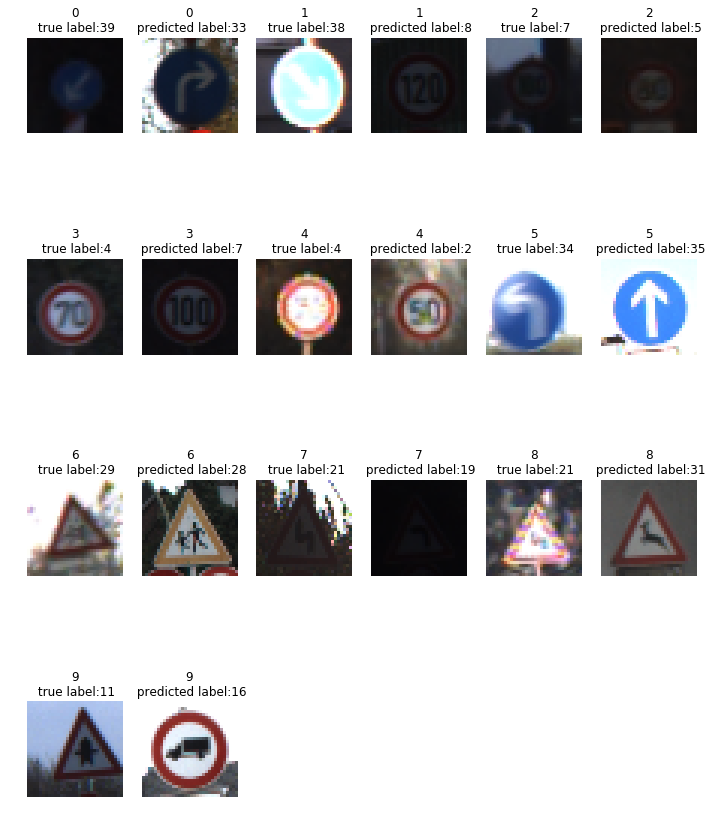

In [24]:
# show false answers
incorrect = (pred_results==False)    # len(incorrect)=1000
images = x_batch[incorrect]          # len(images) = total number of false predicted e.g 41 (of 1000)

false_predict = pred_cls[incorrect]  # len(false_predict) == len(images)

true_labels = true_cls[incorrect]    # len(true_labels)== len(false_predict)==len(images)

# true_list = labels_tr
assert len(images)==len(false_predict)
m = len(images)
plt.figure(figsize=(12,4*m))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
counter = 1

for i in range(m):
    # this is the test image
    plt.subplot(m,6, counter)
    plt.imshow(images[i])
    plt.title("{}\n true label:{}".format(i, true_labels[i]))
    plt.axis('off')
    
    # this is what the model predicted (of course false)
    plt.subplot(m,6,counter+1)
    plt.imshow(images_tr[labels_tr.index(false_predict[i])])
    plt.title("{}\n predicted label:{}".format(i, false_predict[i]))
    plt.axis('off')
    counter +=2
plt.show()


The false predicited signs are very interesting. :) But the last one is not acceptable!

Thank you for your time to reading this notebook